In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [3]:
data=pd.read_csv('/content/Month_Value_3.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 5 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Period                                    96 non-null     object 
 1   Revenue                                   64 non-null     float64
 2   Sales_quantity                            64 non-null     float64
 3   Average_cost                              64 non-null     float64
 4   The_average_annual_payroll_of_the_region  64 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.9+ KB


In [5]:
data['Period'].nunique()

96

In [6]:
p=data[data["Revenue"].notnull()]
p

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0
...,...,...,...,...,...
59,01.12.2019,5.875647e+07,38069.0,1543.420464,29878525.0
60,01.01.2020,5.628830e+07,27184.0,2070.640850,29044998.0
61,01.02.2020,4.022524e+07,23509.0,1711.057181,29044998.0
62,01.03.2020,5.002217e+07,32569.0,1535.882748,29044998.0


We have been given revenue values for continuous 64 months, we have to predict for 32 months 

In [7]:
data['Period']=pd.to_datetime(data['Period'],format="%d.%m.%Y")
data['Period']=data['Period'].dt.to_period('M')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 5 columns):
 #   Column                                    Non-Null Count  Dtype    
---  ------                                    --------------  -----    
 0   Period                                    96 non-null     period[M]
 1   Revenue                                   64 non-null     float64  
 2   Sales_quantity                            64 non-null     float64  
 3   Average_cost                              64 non-null     float64  
 4   The_average_annual_payroll_of_the_region  64 non-null     float64  
dtypes: float64(4), period[M](1)
memory usage: 3.9 KB


In [9]:
ts=data.loc[0:63,['Period','Revenue']]
ts

,Period,Revenue
0,2015-01,1.601007e+07
1,2015-02,1.580759e+07
2,2015-03,2.204715e+07
3,2015-04,1.881458e+07
4,2015-05,1.402148e+07
...,...,...
59,2019-12,5.875647e+07
60,2020-01,5.628830e+07
61,2020-02,4.022524e+07
62,2020-03,5.002217e+07


In [10]:
ts['Month']=ts['Period'].dt.month
ts['Year']=ts['Period'].dt.year
ts.head()

,Period,Revenue,Month,Year
0,2015-01,1.601007e+07,1,2015
1,2015-02,1.580759e+07,2,2015
2,2015-03,2.204715e+07,3,2015
3,2015-04,1.881458e+07,4,2015
4,2015-05,1.402148e+07,5,2015


In [11]:
ts.set_index('Period',inplace=True)
ts.head()

,Revenue,Month,Year
Period,,,
2015-01,1.601007e+07,1,2015
2015-02,1.580759e+07,2,2015
2015-03,2.204715e+07,3,2015
2015-04,1.881458e+07,4,2015
2015-05,1.402148e+07,5,2015


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

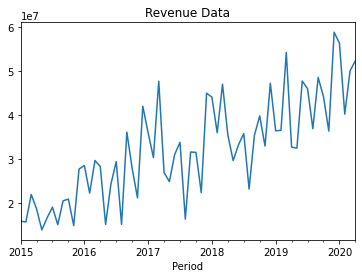

In [13]:
plt.title('Revenue Data')
ts['Revenue'].plot()

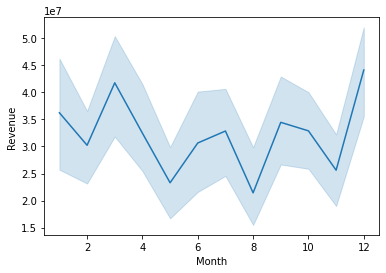

In [14]:
sns.lineplot(x='Month',y='Revenue',data=ts)

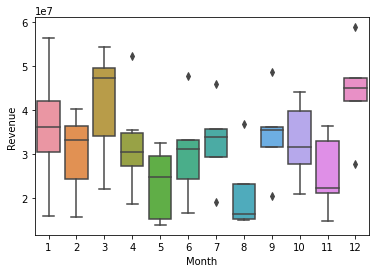

In [15]:
sns.boxplot(x='Month',y='Revenue',data=ts)

It points toward seasonal pattern

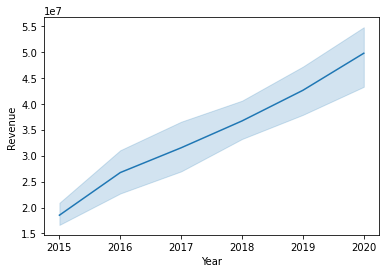

In [16]:
sns.lineplot(x='Year',y='Revenue',data=ts)

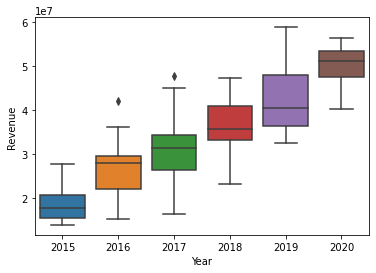

In [17]:
sns.boxplot(x='Year',y='Revenue',data=ts)

This shows there is linearly increasing trend

ADF test for checking the stationarity

In [18]:
from statsmodels.tsa.stattools import adfuller

result=adfuller(ts['Revenue'],autolag='AIC')

print(f'ADF statistics: {result[0]}')
print(f'p-value: {result[1]}')

for key,value in result[4].items():
    print(f'Critical value {key}: {value}')

ADF statistics: -0.2691489356436275
p-value: 0.929761537961779
Critical value 1%: -3.562878534649522
Critical value 5%: -2.918973284023669
Critical value 10%: -2.597393446745562


As p value is greater than 0.05, then null hypothesis cannot be reject.
Therefore the series is non-stationary

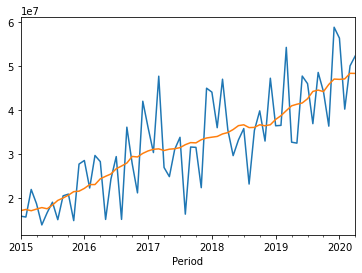

In [19]:
ma=ts['Revenue'].rolling(window=12,center=True,min_periods=6).mean()
ax=ts['Revenue'].plot()
ma.plot(ax=ax)

Accounts for trend and seasonality 

In [20]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)

dp = DeterministicProcess(
    index=ts.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

#data= dp.in_sample()

In [21]:
data.columns


Index(['Period', 'Revenue', 'Sales_quantity', 'Average_cost',
       'The_average_annual_payroll_of_the_region'],
      dtype='object')

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
y = ts["Revenue"]

X= dp.in_sample()

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train, y_test = train_test_split(X,y , random_state=104,  test_size=0.25,  shuffle=False)

In [25]:
model = LinearRegression(fit_intercept=False)
_= model.fit(X_train, y_train)


In [26]:
from sklearn.metrics import r2_score
yp2=model.predict(X_test)
print(r2_score(y_test,yp2))

0.6291739020766709


In [27]:
pip install dynamask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.3 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=52611d7f0bdbef81cd8e672013c5880e38efef10371548872e38ab39eeddc47d
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [28]:
from dynamask.fit.TSX.utils import load_data
import torch
import torch.utils.data as utils
from torch.utils.data import DataLoader
from dynamask.attribution.perturbation import FadeMovingAverage
from  dynamask.attribution.perturbation import GaussianBlur
from torch.nn.functional import mse_loss
from dynamask.attribution.mask import Mask
#from dynamask.models.models import StateClassifier
from dynamask.attribution.mask_group import MaskGroup

In [29]:

def blackbox(x):
    out=model.predict(x.detach().cpu().numpy())
    return torch.tensor(out)

In [30]:
X_test2= dp.out_of_sample(steps=32)

In [31]:
X_test2

,const,trend,"s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)",...,"cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(5,freq=A-DEC)","cos(5,freq=A-DEC)","sin(6,freq=A-DEC)"
2020-05,1.0,65.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.485060,-0.848351,-0.529434,-5.147875e-02,0.998674,0.898292,-0.439400,-0.819972,-0.572404,-1.028210e-01
2020-06,1.0,66.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.861702,-0.874481,0.485060,9.996685e-01,0.025748,-0.848351,-0.529434,0.462383,0.886680,5.147875e-02
2020-07,1.0,67.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.999853,-0.034328,0.999411,5.147875e-02,-0.998674,-0.068615,0.997643,0.085731,-0.996318,-1.028210e-01
2020-08,1.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.870285,0.857315,0.514793,-9.996685e-01,-0.025748,0.882679,-0.469977,-0.536696,0.843776,5.147875e-02
2020-09,1.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.500000,0.866025,-0.500000,-4.898587e-16,1.000000,-0.866025,-0.500000,0.866025,-0.500000,-9.797174e-16
2020-10,1.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.008583,0.017166,-0.999853,9.996685e-01,0.025748,-0.034328,0.999411,-0.999079,-0.042905,5.147875e-02
2020-11,1.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500000,-0.866025,-0.500000,6.123234e-16,-1.000000,0.866025,-0.500000,0.866025,0.500000,-1.224647e-15
2020-12,1.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.861702,-0.874481,0.485060,-9.996685e-01,-0.025748,-0.848351,-0.529434,-0.462383,-0.886680,5.147875e-02
2021-01,1.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00
2021-02,1.0,74.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.860961,0.875892,0.482508,9.995463e-01,-0.030120,0.845249,-0.534373,0.455907,-0.890028,-6.021328e-02


In [32]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('GPU')
else:
    device = torch.device('cpu')
    print('CPU')

CPU


In [33]:
pert = GaussianBlur(device)
mask = MaskGroup(pert, device)

In [36]:
areas = [0.1, .25,0.35,0.45,0.55,0.65,0.66,0.70,0.80]
mask.fit(torch.tensor(X_test2.values, dtype=torch.float), f=blackbox, loss_function=mse_loss, size_reg_factor_init=0.01,area_list=areas,learning_rate=2.5, size_reg_factor_dilation=10000, initial_mask_coeff=0.5, n_epoch=2000, momentum=1.0, time_reg_factor=2)


Epoch 1/2000: error = 2.52e+13 ; size regulator = 0.25 ; time regulator = 0 ; time elapsed = 0.016 s
Epoch 2/2000: error = 2.52e+13 ; size regulator = 0.25 ; time regulator = 8.55e-07 ; time elapsed = 0.0109 s
Epoch 3/2000: error = 2.53e+13 ; size regulator = 0.25 ; time regulator = 0.000314 ; time elapsed = 0.0103 s
Epoch 4/2000: error = 2.54e+13 ; size regulator = 0.25 ; time regulator = 0.000289 ; time elapsed = 0.00974 s
Epoch 5/2000: error = 2.53e+13 ; size regulator = 0.25 ; time regulator = 0.000407 ; time elapsed = 0.0099 s
Epoch 6/2000: error = 2.52e+13 ; size regulator = 0.25 ; time regulator = 0.000379 ; time elapsed = 0.00965 s
Epoch 7/2000: error = 2.54e+13 ; size regulator = 0.25 ; time regulator = 0.000624 ; time elapsed = 0.0113 s
Epoch 8/2000: error = 2.51e+13 ; size regulator = 0.25 ; time regulator = 0.000731 ; time elapsed = 0.0106 s
Epoch 9/2000: error = 2.51e+13 ; size regulator = 0.25 ; time regulator = 0.000701 ; time elapsed = 0.0171 s
Epoch 10/2000: error = 2.

The mask of area 0.25 is the best with error = 9.38e+16.


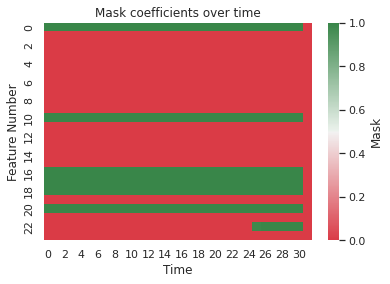

In [37]:
masks = mask.get_extremal_mask(threshold=0.3)
masks.plot_mask(smooth= False, sigma=2.0)

In [38]:
X_test

,const,trend,"s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)",...,"cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(5,freq=A-DEC)","cos(5,freq=A-DEC)","sin(6,freq=A-DEC)"
Period,,,,,,,,,,,,,,,,,,,,,
2019-01,1.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
2019-02,1.0,50.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.860961,0.875892,0.482508,0.999546,-0.030120,0.845249,-0.534373,0.455907,-0.890028,-0.060213
2019-03,1.0,51.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.527078,0.895839,-0.444378,0.094537,-0.995521,-0.796183,-0.605056,-0.933837,0.357698,-0.188227
2019-04,1.0,52.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.021516,0.043022,-0.999074,-0.997917,-0.064508,-0.085965,0.996298,0.994218,0.107381,0.128748
2019-05,1.0,53.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.474951,-0.835925,-0.548843,-0.085965,0.996298,0.917584,-0.397543,-0.785650,-0.618671,-0.171293
2019-06,1.0,54.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.856551,-0.884068,0.467359,0.998435,0.055917,-0.826354,-0.563151,0.417194,0.908818,0.111659
2019-07,1.0,55.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.999667,-0.051620,0.998667,0.077386,-0.997001,-0.103102,0.994671,0.128748,-0.991677,-0.154309
2019-08,1.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.873807,0.849817,0.527078,-0.998880,-0.047321,0.895839,-0.444378,-0.566702,0.823923,0.094537
2019-09,1.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.504961,0.871706,-0.490029,-0.017213,0.999852,-0.854322,-0.519744,0.880012,-0.474951,-0.034422
